# Time Series Classification Using Topological Data Analysis

This notebook shows the basic pipeline of applying Topological Data Analysis for time series classification. We use [Giotto-TDA](https://github.com/giotto-ai/giotto-tda) for working with topology and [UCR](http://www.timeseriesclassification.com/) collection of datasets.

## 0. Imports and Data Loading

In [ ]:
# Giotto Installation:
# !pip install -U giotto-tda

In [155]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score

from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import Scaler, BettiCurve, PersistenceLandscape, PersistenceEntropy
from gtda.plotting import plot_diagram, plot_betti_curves

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from src.utils import *
from src.TFE import *
from src.nn import *
from src import *

In [96]:
directory_list = get_files_directory_list()
directory_list = sorted(directory_list)

random_index =  51
random_path = directory_list[random_index]

X_train, X_test, y_train, y_test = get_data_from_directory(random_path)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()
num_classes = np.unique(y_train).shape[0]

print('Dataset: ', random_path)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape:  ', X_test.shape)
print('y_test shape:  ', y_test.shape)
print('num. of class: ', num_classes)

Dataset:  GunPoint
X_train shape:  (50, 150)
y_train shape:  (50,)
X_test shape:   (150, 150)
y_test shape:   (150,)
num. of class:  2


## 1. Background

### 1.1. Common Pipeline

The core idea of Topological Data Analysis (TDA) is to exploit the topological and geometrical properties of data, like shape, connectivity, and etc. to extract informative features. One of the ways of numerical description of such properties is the *Persistent Homology*. Persistent Homology considers data as a point cloud, and tries to find so called holes in point clouds using discretization and triangulation of initial data space space with simplical complexes. The structure of those wholes are described with *Persistence Diagram* (PD) that is a 2D plot that indicates the birth and death of n-dimensional holes in the induced topological spaces. Then, we can utilize different features to describe PD and use them as a input of classifier.

### 1.2. Point Clouds and Takens' Embedding

Since we are going to work with time series data, we need to represent them in some form that will have informative topological behaviour and allow to extract topological features. One way is to utilize the Taken's embedding theorem [1] as it was proposed, for example, in [2]. This theorem states that time series can be reconstructed in so called *phase space* as:

$$
x_n(m, \tau) = (x_n, x_{n+\tau}, ..., x_{n+(m-1)\tau}),
$$

where $m$ is embedding dimension, $\tau$ is the time delay.

Let's look how it can look like for a sample time series.

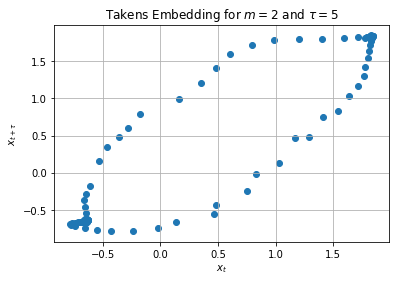

In [97]:
sample_series = X_train[0]
sample_embedding = TakensEmbedding(dimension=2, 
                                   time_delay=5, 
                                   parameters_type='fixed').fit_transform(sample_series)
sample_embedding.shape

plt.scatter(sample_embedding[:,0], sample_embedding[:,1])
plt.xlabel("$x_t$")
plt.ylabel("$x_{t+\\tau}$")
plt.title("Takens Embedding for $m=2$ and $\\tau=5$")
plt.grid()

### 1.3. Persistence Diagram

After obtaining point cloud, it is possible to build a Persistence Diagram (PD). One of the ways of obtaining the PD is the Vietoris-Rips Persistent Homology, as proposed, for example, in [3 https://arxiv.org/abs/1905.06071]. PD shows the distribution of holes - their birth and death - for each *homology dimension*.

In [98]:
sample_pd = VietorisRipsPersistence(homology_dimensions=(0, 1)).fit_transform([sample_embedding])[0]
plot_diagram(sample_pd)

Diagram also can be scaled for normalization.

In [99]:
sample_pd = Scaler().fit_transform([sample_pd])[0]
plot_diagram(sample_pd)

### 1.4. Alternative Persistence Homology Representation

PD is not the only way to represent Persistence Homology. There are some extensions over PD that can also be useful for feature engineering.

#### 1.4.1. Betti Curve

Let $D$ be a PD. *Betti Curve* is a function $\beta_{D}: \mathbb{R} \rightarrow \mathbb{N}$ whose value $s \in \mathbb{R}$ is the number, counted with multiplicity, of points $(b_i , d_i)$ such that $b_i \leq s < d_i$.

In [100]:
betti_curve_extractor = BettiCurve()
sample_betti_curve = betti_curve_extractor.fit_transform([sample_pd])[0]
betti_curve_extractor.plot([sample_betti_curve])

#### 1.4.2. Persistence Landscape

A *Persistence Landscape* is a set of $\{{\lambda_k}\}_{k \in \mathbb{N}}$ of functions $\lambda: \mathbb{R} \rightarrow \overline{\mathbb{R}}$, where $\lambda_k$ is the $k$-th *layer* of Persistence Landscape. For the PD $\{ (b_i, d_i) \}$ Persistence Landscape $\lambda$ can defined as letting $\lambda_k$ be $k$-th largest value on set $\{ \Lambda_i(t) \}$, where $\Lambda_i(t) = \left[ min \{ t-b_i, d_i-t \} \right]_+$ and $c_+ := max(c, 0)$.

In [101]:
persistence_landscape_extractor = PersistenceLandscape(n_layers=2, n_bins=100)
sample_persistence_landscape = persistence_landscape_extractor.fit_transform([sample_pd])[0]
persistence_landscape_extractor.plot([sample_persistence_landscape])

#### 1.4.3. Persistence Entropy

Persistence Entropy is the measure of entropy between points in PD. For PD $D = \{ (b_i, d_i) \}_{i \in I}$ Persistence Entropy is defined by:

$$
E(D) = -\sum_{i \in I} {p_i \log{p_i}},
$$

where $p_i = \frac{d_i - b_i}{L_D}$ and $L_D = \sum_{i \in I}(d_i - b_i)$.

In [102]:
sample_persistence_entropy = PersistenceEntropy().fit_transform([sample_pd])[0]
print(sample_persistence_entropy)

[3.91590105 0.32756594]


### 1.5. Topological Features

After introducing the Persistence Homology and it's derived representations, we can introduced features that we are going to use. Those features will be directly extracted from PD or related sturctures like Betti Curves and Persistence Landscape. First five features are proposed by Pereira in [2], rest of the features are proposed by us. All those topological features were implemented in package `src.TFE`.

#### 1.5.1. Number of Holes

The first feature (or set of features) is the number of holes for each homology dimension. This can be easily calculated with PD. Actually, in the 0th dimension, the holes actually indicate connected components, i.e., vertices that were connected along the filtration.

#### 1.5.2. Maximum Hole Lifetime

Maximum hole lifteime in each dimension helps to identify the most significant hole in each dimension, that is also the farthest point from the diagonal in PD. Note that the one hole that lasted the longest in the filtration indicates a prominent shape-based feature of the data set.

#### 1.5.3. Number of Relevant Holes

The relevant holes for each dimension are the wholes whos lifetime is equal to the maximum hole lifetime with some ratio. In other words, they are the points that are at similar distance from the PD diagonal as the farthest point.

#### 1.5.4. Average Hole Lifetime

Average hole lifetime for each dimensions shows whether the data consist of mosly short-lived holes, or vice versa, the long-lived holes.

#### 1.5.5.  Sum of All Lifetimes

A sum of all hole lifetimes in each dimension can considered as an integral of PD graph. Actually, small sum for dimension shows that data has practically no holes in this dimension.

#### 1.5.6. Pesistence Entropy

Persistence Entropy actually is already a feature and can be informative.

#### 1.5.7. Average Number of Simultaneously Existing Holes

Average number of holes that exist simultaneously for each dimension in some sense can help to describe how sparse the holes are distributed for each dimension. If we represent the PD as set of sorted segments, which is also known as *Persistence Barcode*, this feature can be calculated as an average number of intersections of those segments.

#### 1.5.8. Average Value of Persistence Landscape

Average value of Persistence Landscape can help to handle the structure of Persistence Landscape diagram which can be informative. It's important to notice that in almost all of the studeid cases only Persistence Landscape for 1st homology dimension is informative, so we count this feature only for the 1st homology dimension.

#### 1.5.9. Sum of Betti Numbers

Sum of Betti Numbers can be considered as an integral of Betti Curve for each dimension. This feature is introduced to handle the structure of Betti Curves.

#### 1.5.10. Radius at Maximum Betti Number

This feature is inspired by work [5 Umeda]. It is actually the relative value of $s$ that corresponds to the maximum Betti number for each dimension.

## 2. Evaluation for Sample UCR Dataset

In this part we are going to extract topological features for the dataset [GunPoint](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint) from UCR collection of datasets. The same pipeline was applied to the rest of 1-dimensional time series datasets in UCR.

### 2.1. Topological Features Extraction

To extract Persistence Diagrams and corresponding features, we implemented own scikit-learn style transformers that we used for convenient feature extraction.

In [104]:
%%time

feature_extractor = TopologicalFeaturesExtractor(
    persistence_diagram_extractor=PersistenceDiagramsExtractor(tokens_embedding_dim=2, 
                                                               tokens_embedding_delay=10,
                                                               homology_dimensions=(0, 1),
                                                               parallel=True),
    persistence_diagram_features=[HolesNumberFeature(),
                                  MaxHoleLifeTimeFeature(),
                                  RelevantHolesNumber(),
                                  AverageHoleLifetimeFeature(),
                                  SumHoleLifetimeFeature(),
                                  PersistenceEntropyFeature(),
                                  SimultaneousAliveHolesFeatue(),
                                  AveragePersistenceLandscapeFeature(),
                                  BettiNumbersSumFeature(),
                                  RadiusAtMaxBNFeature()])

X_train_transformed = feature_extractor.fit_transform(X_train)
X_test_transformed = feature_extractor.fit_transform(X_test)

CPU times: user 12.2 s, sys: 997 ms, total: 13.2 s
Wall time: 14.5 s


In [105]:
print('X_train_transformed shape: ', X_train_transformed.shape)
print('X_test_transformed shape:  ', X_test_transformed.shape)

X_train_transformed shape:  (50, 19)
X_test_transformed shape:   (150, 19)


### 2.2. Model Selection in Extracted Features Space

Now we are going to train different models and try to find the best parameters for them using cross-validation technique.

In [107]:
def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    clf_cv = GridSearchCV(model, 
                          param_grid=parameters,
                          cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
                          scoring='accuracy', 
                          n_jobs=-1)
    clf_cv.fit(X_train, y_train)
    acc_train = accuracy_score(y_train, clf_cv.best_estimator_.predict(X_train))
    acc_test = accuracy_score(y_test, clf_cv.best_estimator_.predict(X_test))
    print(clf_cv.best_estimator_.__class__.__name__)
    print(clf_cv.best_params_)
    print("Train accuracy: ", acc_train)
    print("Test accuracy: ", acc_test)
    return acc_train, acc_test, clf_cv.best_estimator_, clf_cv.best_params_

Support Vector Machine:

In [117]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

SVC
{'C': 0.1, 'kernel': 'linear'}
Train accuracy:  0.98
Test accuracy:  0.86


XGBoost:

In [113]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.9


K Nearest Neighbours:

In [115]:
parameters = {"n_neighbors": [3, 5, 7, 11,]}
acc_train, acc_test, model, model_params = evaluate_model(KNeighborsClassifier(n_jobs=-1), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

KNeighborsClassifier
{'n_neighbors': 5}
Train accuracy:  0.96
Test accuracy:  0.8533333333333334


CatBoost:

In [118]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}
acc_train, acc_test, model, model_params = evaluate_model(CatBoostClassifier(random_state=42, verbose=False), 
                                                          parameters, X_train_transformed,
                                                          y_train, X_test_transformed, y_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CatBoostClassifier
{'early_stopping_rounds': 2, 'max_depth': 2, 'n_estimators': 50}
Train accuracy:  0.98
Test accuracy:  0.9


### 2.3 Dimensionality Reduction with Variational Autoencoder

Variational Autoencoder (VAE) is a powerful dimensionality reduction technique. We are going to apply it to reduce the extracted topoligcal features space dimensionality.

In [119]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

device = get_device()
batch_size = 32
latent_dim = num_classes * 4

In [122]:
scale = StandardScaler()
scale.fit(X_train_transformed)

X_train_transformed_dim = handle_dim(X_train_transformed, scale)
X_test_transformed_dim = handle_dim(X_test_transformed, scale)

y_hot_train = one_hot_encoding(y_train)
y_hot_test = one_hot_encoding(y_test)

dataset_train = TimeSeriesDataLoader(X_train_transformed_dim, y_hot_train, batch_size)
dataset_test = TimeSeriesDataLoader(X_test_transformed_dim, y_hot_test, batch_size)

test_data = torch.zeros(dataset_train.dataset[:][0].shape)

In [123]:
vae = VariationalAutoencoder(batch_size=batch_size, latent_dims=latent_dim, test_data=test_data)
vae = vae.to(device)

optimizer = torch.optim.Adam(params=vae.parameters(), lr=2e-3, weight_decay=1e-5)
num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 13873


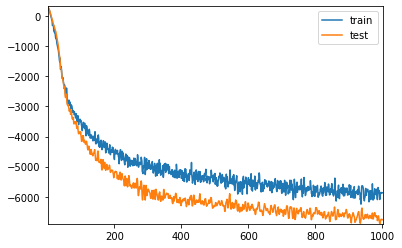

VariationalAutoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (conv2): Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (fc_mu): Linear(in_features=256, out_features=8, bias=True)
    (fc_logvar): Linear(in_features=256, out_features=8, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=8, out_features=96, bias=True)
    (conv2): ConvTranspose1d(32, 1, kernel_size=(15,), stride=(3,), padding=(1,))
  )
)

In [124]:
train_AE(1000, vae, dataset_train, dataset_test, optimizer, device, verbose=True)

In [125]:
from_vae_loader2numpy = lambda model, x: model.transform(x.dataset[:][0]).cpu().detach().numpy()

z_train = from_vae_loader2numpy(vae, dataset_train)
z_test = from_vae_loader2numpy(vae, dataset_test)

In [128]:
print("Reduced train size: ", z_train.shape)

Reduced train size:  (50, 8)


Now let's train our models on reduced dataset.

Support Vector Machine:

In [129]:
parameters = {"C": [10**i for i in range(-2, 5)],
              "kernel": ["linear", "rbf", "sigmoid", "poly"]}
acc_train, acc_test, model, model_params = evaluate_model(SVC(random_state=42), parameters, z_train,
                                                          y_train, z_test, y_test)

SVC
{'C': 10, 'kernel': 'sigmoid'}
Train accuracy:  0.98
Test accuracy:  0.9266666666666666


XGBoost:

In [130]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250]}
acc_train, acc_test, model, model_params = evaluate_model(XGBClassifier(n_jobs=-1, random_state=42), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

XGBClassifier
{'max_depth': 2, 'n_estimators': 20}
Train accuracy:  1.0
Test accuracy:  0.8266666666666667


K Nearest Neighbours:

In [131]:
parameters = {"n_neighbors": [3, 5, 7, 11,]}
acc_train, acc_test, model, model_params = evaluate_model(KNeighborsClassifier(n_jobs=-1), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

KNeighborsClassifier
{'n_neighbors': 5}
Train accuracy:  0.98
Test accuracy:  0.8733333333333333


CatBoost:

In [132]:
parameters = {"max_depth": [2, 10, 15, 20, 25, 30, 35, 40, 45, 50, 70, 100, 120, 150],
              "n_estimators": [20, 50, 100, 150, 200, 250],
              "early_stopping_rounds": [2, 5, 8, 10, 50, 200]}
acc_train, acc_test, model, model_params = evaluate_model(CatBoostClassifier(random_state=42, verbose=False), 
                                                          parameters, z_train,
                                                          y_train, z_test, y_test)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



CatBoostClassifier
{'early_stopping_rounds': 2, 'max_depth': 15, 'n_estimators': 200}
Train accuracy:  1.0
Test accuracy:  0.9066666666666666


In this case, VAE helped to achieve best accuracy on test set.

### 2.4. ANN classifier

Finally, let's try to use an ANN as a classifier.

In [152]:
neural_net_params = {'in_features=latent_dim': latent_dim,
                     'out_features': num_classes,
                     'depth': 4}

net = ANN(latent_dim, num_classes, device)
net.fit(z_train, y_train)

y_train_pred = net.predict(z_train)
y_test_pred = net.predict(z_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print("Accuracy on train: ", acc_train)
print("Accuracy on test: ", acc_test)

NameError: name 'ANN' is not defined

## 3. Imputation Study

TODO

## 4. Conclusions

TODO